# Ch3.Graphical Causal Models

3장에서는 1장에서 배운 식별과 추정에서 **식별** 부분을 더 자세히 다룬다. 또한 데이터로 매개변수를 추정하지 않고 그래프 모델(graphical model)을 다루며 대부분 이론적인 내용이다. 식별은 인과추론의 핵심이므로 식별 이론 학습은 실생활에서 인과적 문제를 해결하는 데 기본이 된다. 이번 장에서는 다음과 같은 내용을 다룬다.  
- 그래프 모델을 소개하면서 그래프 인과모델과 그래프에서 연관성이 어떻게 흐르는지, 기존 라이브러리를 사용하여 그래프를 쿼리(query)하는 법을 배운다.  
- 그래프 모델을 통해서 식별의 개념을 재해석한다.  
- 흔히 식별을 방해하는 편향의 원인 두 가지와 인과 그래프 구조를 바탕으로 할 수 있는 일을 알아본다.

---

## 3.1 인과관계와 그래프

잘 표현된 언어는 명확하게 생각하도록 만든다. 곧 배울 그래프 모델은 인과관계의 기본 언어 중 하나라고 볼 수 있다. 그래프 모델은 인과추론 문제를 **구조화**하며, 식별 가정을 명확하게 시각적으로 표현하는 강력한 방법이다. 즉 **그래프 모델은 생각을 명확하게 표현하도록 도와준다.**

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● 구조적 인과모델</strong><br>
    일부 과학자들은 인과추론의 통일된 언어를 지칭하는데 구조적 인과모델(Structural Causal Model,SCM)이라는 용어를 사용한다. 이 모델은 그래프와 인과 방정식(Causal equation)으로 구성된다. 이번 장에서는 주로 SCM의 그래프 측면에 초점을 맞춰 설명한다.
</div>

예시로, 교차 판매 이메일이 전환에 미치는 영향을 추정한 사례를 다시 살펴본다. 여기서 처치 $T$는 교차 판매 이메일이고 결과 $Y$는 고객이 신규 제품으로의 전환 여부를 나타낸다.

In [1]:
import numpy as np
import pandas as pd

url= "https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/cross_sell_email.csv"

data=pd.read_csv(url)
data

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0
...,...,...,...,...
318,0,long,18,0
319,1,no_email,16,0
320,0,no_email,15,0
321,1,no_email,16,0


해당 사례에서, $T$는 무작위로 배정되었다. 따라서 처치는 잠재적 결과와 독립이라고 ($(Y_0,Y_1) \bot T$) 볼 수 있으며, 상관관계를 인과관계로 만든다.
$$
E[Y_1-Y_0] = E[Y\ |\ T=1]-E[Y\ |\ T=0]
$$
중요한 것은 단지 데이터만 보고 독립성 가정이 성립한다고 애기할 수는 없다는 점이다. 앞서 논의했듯이, 실험 대상에게 처치 배정에 관한 매커니즘 정보가 있어야 독립성 가정이 유지된다고 할 수 있다. 여기서는 무작위로 고객에게 이메일이 발송되었음을 알기 때문에 독립성 가정이 성립한다고 볼 수 있다.

### 인과관계 시각화

교차 판매 이메일이 전환을 유도하고 관측된 다른 변수인 나이와 성별도 전환의 원인이 된다고 생각해보자. 또한 관측되지 않은 변수는 $U$로 표시한다. 예를 들어, 고객 소득, 사회적 배경, 나이(회사가 서비스하는 도시에서 제품이 다양한 인구 집단에 어떻게 어필되는지에 관한 정보)와 같이 전환을 유도하는 관측되지 않은 변수가 많을 것이다. 해당 변수들은 측정하지 않을 것이므로, 측정되지 않은 모든 변수를 나타내는 $U$ 노드(node)에 묶어서 표현한다. 마지막으로 $T$(처치)를 가리키는 랜덤화 노드를 추가하여 교차 판매 이메일이 무작위로 발생되었다는 구조를 나타낼 수 있다.

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● DAG</strong><br>
    인과 그래프를 DAG라고 부르기도 한다. DAG는 <b>유향 비순환 그래프</b>(directed acyclic graph)의 약자이다. 방향이 있는 부분은 없는 부분과 달리, SNS처럼 엣지(edge)에 방향성을 나타낸다. 비순환 부분은 그래프에 루프나 순환(cycle)이 없음을 나타낸다. 인과관계에는 되돌릴 수 없는 비가역적(non-invertible) 가정이 있으므로 인과 그래프는 일반적으로 방향성있는 비순환 그래프이다.
</div>

다음과 같이 그래프 시각화 라이브러리 `graphviz`를 사용해서 그래프를 활용해 시각화할 수 있다.

In [7]:
import graphviz as gr

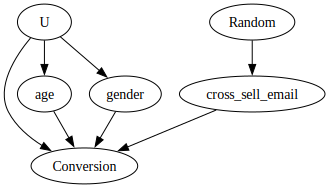

In [12]:
g_cross_sell = gr.Digraph()

g_cross_sell.edge('U','Conversion')
g_cross_sell.edge('U','age')
g_cross_sell.edge('U','gender')

g_cross_sell.edge('Random','cross_sell_email')
g_cross_sell.edge('cross_sell_email','Conversion')
g_cross_sell.edge('age','Conversion')
g_cross_sell.edge('gender','Conversion')

g_cross_sell

그래프의 각 노드는 **확률변수(Random Variable,RV)** 이다. 화살표나 엣지를 사용하여 한 변수가 다른 변수의 원인이 되는지 표시할 수 있다. 이 그래프 모델에서는 전환의 원인은 이메일이 되고, $U$가 나이,전환,성별 등 변수의 원임임을 나타낸다. 이 그래프 모델 언어는 세상이 어떻게 작동하는지에 관한 믿음을 명확하게 반영하므로 인과관계에 대한 생각을 표현하는 데 도움이 된다. 그런데 오늘날 데이터 적용 사례에 일반적으로 존재하는 수백 개의 변수를 모두 그래프에 표현할 방법은 없다. 따라서 이 부분이 얼마나 비현실적인지 고민할 필요가 없다. 실제로 전달하려는 일반적인 인과 구조를 유지하면서 노드를 묶어 획기적으로 그래프를 단순화할 수 있다.  
예를 들어, 앞의 그래프를 가지고 관측 가능한 변수를 $X$ 노드로 묶을 수 있다. 두 변수 $U$에 의해 발생하고 전환의 원인이 되므로 이들을 결합해도 인과 구조는 그대로 유지된다.  
또한 무작위로 배정되거나 개입된 변수를 표현할 때는 들어오는 화살표를 모두 제거하면 된다.

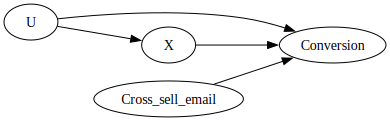

In [13]:
# rankdir : LR인 경우, 그래프가 왼쪽에서 오른쪽으로 화살표가 향하도록 설정
g_cross_sell = gr.Digraph(graph_attr={'rankdir':"LR"})

g_cross_sell.edge('U','Conversion')
g_cross_sell.edge('U','X')

g_cross_sell.edge('Cross_sell_email','Conversion')
g_cross_sell.edge('X','Conversion')

g_cross_sell

여기서 흥미로운 점은 DAG에서 가장 중요한 정보는 **그래프 안에서 누락될 수도 사실**이다. 즉, 한 변수에 다른 변수로 연결되는 엣지가 없다는 것은 두 변수 사이에 직접적인 인과관계가 없다고 가정한다는 의미이다. 예를 들어, 앞의 그래프에서는 처치와 결과, 두 노드 **모두**에게 영향을 주는 원인이 없다고 가정한다.

이 부분을 읽으면서 내용이 완전히 이치에 맞지 않는다고 생각할 수 있으며, 이해가 안되는 것이 지극히 정상이다. 하지만 지금은 그래프가 상관관계는 인과관계가 아닌 이유를 이해하는 데 매우 강력한 도구임을 기억하자.

### 컨설턴트 영입 여부 결정하기

처치가 랜덤화되지 않은 예제를 살펴보며 DAG의 유용함을 알아본다. 만약 여러분이 최고 수준의 컨설턴트 영입 여부를 고려하는 회사의 관리자라고 생각해보자. 컨설턴트의 몸값이 비싸다는 것을 알지만, 그들이 업계 최고의 회사와 함께 일하며 쌓은 전문 지식을 보유했다는 것도 안다. 수익성이 매우 좋은 회사만 최고 수준의 컨설턴트를 고용할 수 있기 때문에 그러한 컨설턴트를 고용했을 때 비즈니스를 개선할 수 있는지, 그들의 존재가 좋은 회사의 실적(수익으로 측정)과 상관관계가 있는 건지 확신할 수 없다. 회사마다 컨설턴트를 무작위로 배정받을 수 있다면 최고 수준의 컨설턴트 고용이 얼마나 효과적인지 쉽게 답할 수 있지만, 현실적으로 어렵기에 다른 방법을 생각해 내야 한다. 이는 상관관계로부터 인과관계를 풀어야 하는 문제이다. 인과관계 메커니즘에 관한 생각을 다음과 같이 그래프로 표현해서 이를 이해할 수 있다.

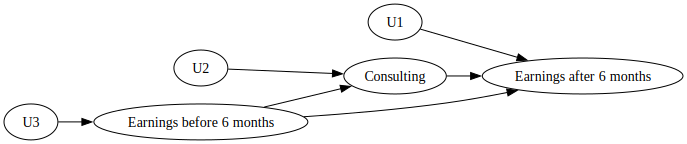

In [14]:
g_consulting = gr.Digraph(graph_attr={'rankdir':'LR'})

g_consulting.edge('U1','Earnings after 6 months')
g_consulting.edge('U2','Consulting')
g_consulting.edge('U3','Earnings before 6 months')

g_consulting.edge('Consulting','Earnings after 6 months')
g_consulting.edge('Earnings before 6 months','Consulting')
g_consulting.edge('Earnings before 6 months','Earnings after 6 months')

g_consulting

측정할 수 없는 다른 요소가 변수의 원인이라는 사실을 나타내려고 각 변수에 $U$ 노드를 추가한 부분을 보자. 그래프는 일반적으로 확률변수를 나타내므로 임의의 $U$가 모든 변수의 원인이 될 것으로 예상할 수 있다. 그러나 이러한 요소는 인과 구조에 영향을 주지 않을 것이므로 생략하는 편이 좋다.

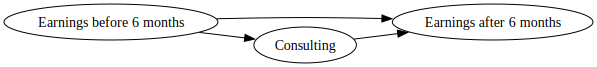

In [16]:
g_consulting = gr.Digraph(graph_attr={'rankdir':'LR'})

g_consulting.edge('Earnings before 6 months','Earnings after 6 months')
g_consulting.edge('Earnings before 6 months','Consulting')
g_consulting.edge('Consulting','Earnings after 6 months')

g_consulting

이 사례에서 회사의 과거 실적이 최고 수준이 컨설턴트를 고용하게 한다고 애기한다. 회사가 잘 된다면 비싼 서비스 비용을 지불할 수 있지만, 실적이 좋지 않다면 지불할 여유가 없다. 따라서 과거 실적이 컨설턴트를 고용할 확률을 결정한다. 이 관계가 반드시 결정적(Deterministic)이지 않다는 점을 기억하자. 단지 **실적이 좋은 회사가 최고 수준의 컨설턴트를 고용할 가능성이 더 높다는 의미**이다.

그뿐만 아니라 지난 6개월 동안 잘된 회사는 이후 6개월 동안에도 잘될 가능성이 매우 높다. 물론 항상 그렇지는 않지만, 평균적으로 그렇기 때문에 과거 실적에서 미래 실적까지의 엣지를 추가했다. 마지막으로 컨설팅으로부터 회사의 미래 실적에 관한 엣지를 추가했다. 목표는 이러한 그래프 연결의 강점을 파악하는 것이며, 이 연결이 우리가 관심 있는 인과관계이다.

컨설팅이 실제로 회사의 실적을 높이는지에 대한 답을 하기는 간단하지 않다. 컨설팅과 미래 실적 사이의 연관성에는 두 가지 원인이 있다. 하나는 인과관계이지만 다른 하나는 인과관계가 아니다. 이를 이해하고 구분하려면 먼저 인과 그래프에서 연관성이 어떻게 흐르는지 간단히 살펴봐야 한다.

---

## 3.2 그래프 모델의 구조